In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import scipy.stats as stats
import re
from dateutil import parser
import matplotlib.pyplot as plt
import stargazer

In [3]:
coaches_poll = pd.read_csv('coaches_poll.csv')
race_results = pd.read_csv('race_results.csv')
eastern_sprints = pd.read_csv('sprints_results.csv')

In [4]:
# Preprocessing the DataFrame
coaches_poll = coaches_poll.drop(columns=['Unnamed: 0'])
race_results = race_results.drop(columns=['Unnamed: 0'])

In [5]:
# Adjusting objects
eastern_sprints['Date'] = pd.to_datetime(eastern_sprints['Date'])
eastern_sprints['Date'] = eastern_sprints['Date'].dt.strftime('%Y-%m-%d')
coaches_poll['Date'].apply(lambda x: datetime.strptime(' '.join(x.split()[:3]), '%B %d, %Y'))
race_results['Date'].apply(lambda x: datetime.strptime(' '.join(x.split()[:3]), '%Y-%m-%d'))
coaches_poll['Date'] = pd.to_datetime(coaches_poll['Date'])
coaches_poll['year'] = coaches_poll['Date'].dt.year
race_results['Date'] = pd.to_datetime(race_results['Date'])
race_results['year'] = race_results['Date'].dt.year
coaches_poll['Team'] = coaches_poll['Team'].astype('string')

In [6]:
# Encoding correctly
unique_tags = list(coaches_poll['Team'].dropna())
tags = list(set([item for item in unique_tags if len(item) == 3]))
tags[5] = 'COLG'
tags.append('COLU')
tags.append('MARI')
tags.append('DREX')
tags.append('TEMP')

In [7]:
def replace_substring(text, substring_list):
    pattern = '|'.join(substring_list)
    regex = re.compile(pattern, flags=re.IGNORECASE)
    match = regex.search(text)
    if match:
        return match.group()
    else:
        return text
race_results['Team'] = race_results['Team'].apply(lambda x: replace_substring(x, tags))
coaches_poll['Team'] = coaches_poll['Team'].apply(lambda x: replace_substring(str(x).lower(), tags))
eastern_sprints['Team'] = eastern_sprints['Team'].apply(lambda x: replace_substring(x, tags))
race_results['Team'] = race_results['Team'].str.upper()
eastern_sprints['Team'] = eastern_sprints['Team'].str.upper()
coaches_poll['Team'] = coaches_poll['Team'].str.upper()

eastern_sprints['year'] = eastern_sprints['Date'].apply(lambda x: int(x[:4]))

In [8]:
# Never thought there would be so many different ways to spell out the boat. 
boat_dictionary = {
    'Varsity 8': '1V',
    '2nd Varsity 8': '2V',
    '3rd Varsity 8': '3V',
    '4th Varsity 8': '4V',
    '4V/5V': '4V/5V',
    'Fourth Varsity 8': '4V',
    '3V Eight': '3V',
    'Third Varsity 8': '3V',
    'Varsity 8:': '1V',
    '2nd Varsity 8:': '2V',
    '3rd Varsity Eights':'3V'
}
# Now we replace weird boat names with the Correct identifier
race_results['Boat_correct'] = race_results['Boat'].replace(boat_dictionary) 

In [9]:
# # Let's start building out the algorithm
# # Build function finds first ranking:
# test_race = race_results.loc[race_results['year'] == 2022]
# test_frame = coaches_poll.loc[coaches_poll['year'] == 2022]
# min_value = test_frame['Date'].min()
# dates_unique = test_frame['Date'].unique()

In [10]:
def assign_winners_losers(frame):
    # Check is missing data in it
    frame = frame.dropna(subset=['Time'])
    frame = frame[(frame['Time'] != '---') & (frame['Time'] != '------')]
    try:
        frame['Time'] = pd.to_datetime([x.rstrip('*') for x in frame['Time']], format='%M:%S.%f')
    except ValueError:
        frame['Time'] = pd.to_datetime([x[:-4].rstrip('*') for x in frame['Time']], format='%M:%S')
    # Group the dataframe by the 'Date' and 'Notes' columns, and rank the rows by their finishing times
    frame['Rank'] = frame.groupby(['Date_place'])['Time'].rank(method='dense')
    frame['Points'] = frame['Rank'].apply(lambda x: 1 if x == 1.0 else 0)
    # except:
    #     print('Found error')
    return frame

In [11]:
def assign_winners_losers(frame):
    # Check for missing data
    frame = frame.dropna(subset=['Time'])
    frame = frame[(frame['Time'] != '---') & (frame['Time'] != '------')]

    # Parse the time strings using dateutil.parser.parse
    def parse_time(time_str):
        try:
            time_str = time_str.rstrip('*')
            return parser.parse(time_str).time()
        except ValueError:
            return None

    frame['Time'] = frame['Time'].apply(parse_time)
    frame = frame.dropna(subset=['Time'])

    # Group the dataframe by the 'Date' and 'Notes' columns, and rank the rows by their finishing times
    frame['Rank'] = frame.groupby(['Date_place'])['Time'].rank(method='dense')
    frame['Points'] = frame['Rank'].apply(lambda x: 1 if x == 1.0 else 0)

    return frame

In [12]:
# race_results_1 = race_results.loc[(race_results['year'] == 2022) & (race_results['Boat_correct'] == '1V')]
# frame = assign_winners_losers(race_results_1)
# frame


In [13]:
def parse_input_data(df):
    grouped_data = df.groupby('Date_place')

    match_data = []
    for _, group in grouped_data:
        matches = group.to_dict('records')
        for match in matches:
            team1 = match['Team']
            result1 = match['Points']
            for other_match in matches:
                if other_match['Team'] != team1:
                    team2 = other_match['Team']
                    result2 = other_match['Points']
                    winner = team1 if result1 > result2 else team2
                    match_data.append((team1, team2, winner))
                    break

    return match_data

def colley_algorithm(df):
    parsed_data = parse_input_data(df)

    teams = {}
    for row in parsed_data:
        team1, team2, winner = row
        if team1 not in teams:
            teams[team1] = {"index": len(teams), "wins": 0, "losses": 0}
        if team2 not in teams:
            teams[team2] = {"index": len(teams), "wins": 0, "losses": 0}

        if winner == team1:
            teams[team1]["wins"] += 1
            teams[team2]["losses"] += 1
        else:
            teams[team2]["wins"] += 1
            teams[team1]["losses"] += 1

    n = len(teams)
    C = np.identity(n) * 2
    b = np.ones((n, 1))

    for row in parsed_data:
        team1, team2, winner = row
        i, j = teams[team1]["index"], teams[team2]["index"]
        C[i][i] += 1
        C[j][j] += 1
        C[i][j] -= 1
        C[j][i] -= 1
        if winner == team1:
            b[i] += 0.5
            b[j] -= 0.5
        else:
            b[j] += 0.5
            b[i] -= 0.5

    r = np.linalg.solve(C, b)

    rankings = {team: r[teams[team]["index"]][0] for team in teams}
    sorted_rankings = sorted(rankings.items(), key=lambda x: x[1], reverse=True)

    return sorted_rankings

In [14]:
def generate(boat):
    years = [2022, 2019, 2018, 2017]
    result_standings = []
    colley_rankings = []
    coaches_poll_year = []
    unique_dates = eastern_sprints['Date'].unique()
    for i, year in enumerate(years):
        try:
            res = assign_winners_losers(race_results.loc[(race_results['year'] == year) & (race_results['Boat_correct'] == boat)])
        except ValueError:
            print(f'Year that couldnt convert times is {year}')
            try:
                frame = race_results.loc[(race_results['year'] == year) & (race_results['Boat_correct'] == boat)]
                frame['Time'] = frame['Time'].apply(lambda x: x[:-4])
                res = assign_winners_losers(frame)
            except ValueError:
                print('even changing time did not helped')
            continue
        coach_poll = coaches_poll.loc[coaches_poll['year'] == year]
        unique_dates = coach_poll['Date'].unique()
        rankings_ls = []
        poll_ls = []
        for dates in np.flip(unique_dates):
            rankings = colley_algorithm(res.loc[res['Date'] < dates])
            rankings_ls.append(rankings)
            coach_poll = coaches_poll.loc[(coaches_poll['Date'] == dates) & (coaches_poll['Boat'] == boat)]
            poll_ls.append(coach_poll['Team'])
        colley_rankings.append(rankings_ls)
        coaches_poll_year.append(poll_ls)
        eastern_sprints_frame = eastern_sprints.loc[(eastern_sprints['year'] == year) & (eastern_sprints['Boat'] == boat)]
        result_standings.append(eastern_sprints_frame['Team'])

    colley = []
    for i in colley_rankings:
        ls = []
        for n in i:
            rs = [x[0] for x in n]
            ls.append(rs)
        colley.append(ls)
    return result_standings, colley_rankings, coaches_poll_year, colley

result_standings, colley_rankings, coaches_poll_year, colley = generate('1V')

In [15]:
pd.DataFrame(coaches_poll_year[0][0])

,Team
372,YAL
373,HAR
374,DAR
375,SYR
376,BRO
377,NOR
378,PRI
379,COR
380,NAV
381,WIS


In [16]:
pd.DataFrame(result_standings)

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
Team,YAL,BRO,DAR,PRI,HAR,SYR,NOR,WIS,BU,COR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Team,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Team,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Team,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,BRO,COR,SYR,WIS,PEN,G WASHINGTON,COL,NOR,NAV,GEORGETOWN


In [17]:
# result_standings = [x.values for x in result_standings]
# coaches_poll_year = [x.values for x in coaches_poll_year]

# Now using kendall Tau to evaluate predictions\
def calculate_kendalltau(ls, y):
    '''
    Input list of list with the rankings returns list of kendall tau values.
    Input y -> list of list with true labels
    '''
    result = []
    for i, items in enumerate(ls):
        tau_values = []
        for n in items:
            tau, p_value = stats.kendalltau(n[:10], y[i][:10])
            tau_values.append(tau)
        result.append(tau_values)
    return result

kendall_colley = calculate_kendalltau(colley, result_standings)
kendall_coaches = calculate_kendalltau(coaches_poll_year, result_standings)

/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


In [18]:
years = [2022, 2019, 2018, 2017]

In [19]:
print(colley[0][3])
print(colley[0][2])

['YAL', 'DAR', 'HAR', 'BRO', 'PRI', 'NOR', 'SYR', 'COR', 'NAV', 'COL', 'MIT', 'BOS', 'OREGON STATE', 'PEN', 'DREX', 'GWU', 'HOBART', 'GEORGETOWN', 'WIS', 'TEMP', 'RUT', 'HOL', 'MARI']
['YAL', 'DAR', 'HAR', 'PRI', 'SYR', 'NOR', 'WIS', 'COL', 'BRO', 'GEORGETOWN', 'MIT', 'DREX', 'PEN', 'COR', 'TEMP', 'NAV', 'HOL', 'MARI', 'BOS']


In [20]:
stats.kendalltau(colley[1][3][:10], result_standings[0][:10])

KendalltauResult(correlation=-0.37777777777777777, pvalue=0.1557418430335097)

In [21]:
stats.kendalltau(colley[1][2][:10], result_standings[0][:10])

KendalltauResult(correlation=-0.37777777777777777, pvalue=0.1557418430335097)

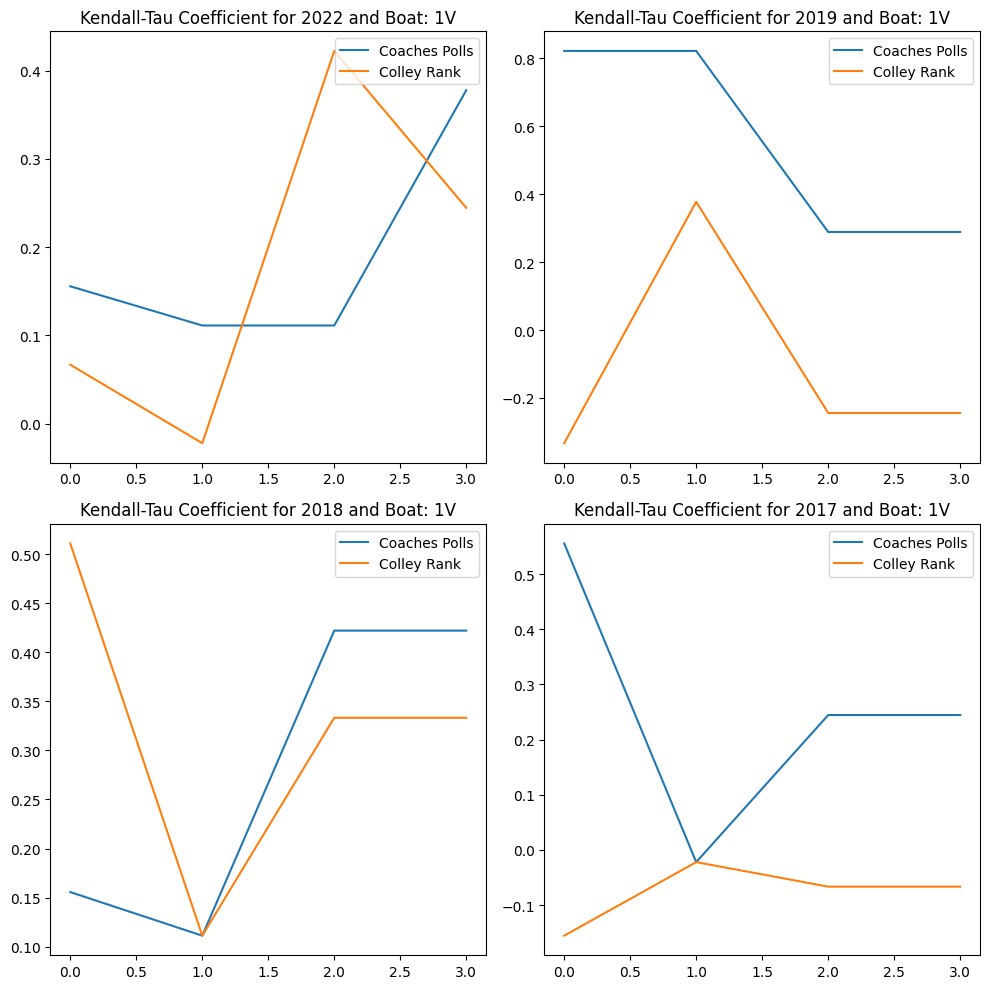

In [47]:
year_ls = [2022, 2019, 2018, 2017]
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,2, figsize=(10,10))
for i, year in enumerate(years):
    ax[i//2, i%2].set_title(f'Kendall-Tau Coefficient for {year_ls[i]} and Boat: 1V')
    ax[i//2, i%2].plot(kendall_coaches[i], label='Coaches Polls')
    ax[i//2, i%2].plot(kendall_colley[i], label='Colley Rank')
    ax[i//2, i%2].legend(loc='upper right')
plt.tight_layout()
plt.savefig('kendall_tau_coeff')

In [23]:
def hot_cold(list1, list2):
    result = []
    for item in list1:
        if item in list2:
            index1 = list1.index(item)
            index2 = list2.index(item)
            
            if index1 > index2:
                result.append(-1)
            elif index1 < index2:
                result.append(1)
            else:
                result.append(0)
        else:
            result.append(0)
    return result

# hot_cold(list(coaches_poll_year[0][0]),list(coaches_poll_year[0][1]))

In [24]:
def hot_cold(list1, list2):
    result = {}
    for item in list1:
        if item in list2:
            index1 = list1.index(item)
            index2 = list2.index(item)

            if index1 > index2:
                result[item] = -1
            elif index1 < index2:
                result[item] = 1
            else:
                result[item] = 0
        else:
            result[item] = 0
    return result

In [25]:
# def hot_cold(list1, list2):
#     encoded_dict = {}
#     for element in list1:
#         try:
#             index1 = list1.index(element)
#             index2 = list2.index(element)
#             encoded_dict[element] = 1 if index2 < index1 else 0
#         except ValueError:
#             encoded_dict[element] = float('nan')
#     return encoded_dict


In [26]:
def formatting(coaches_poll_year, colley):
    #result_standings, colley_rankings, coaches_poll_year, colley
    hot_cold_coaches_poll = []
    for i in range(0, len(coaches_poll_year)):
        hot_cold_coaches_poll.append(hot_cold(list(coaches_poll_year[i][0][:10]), list(coaches_poll_year[i][1][:10])))

    hot_cold_colley = []
    for i in range(0, len(colley)):
        hot_cold_colley.append(hot_cold(list(colley[i][0][:10]), colley[i][1][:10]))

    return hot_cold_coaches_poll, hot_cold_colley

# Get results for all Boats
boat_types = ['4V', '3V', '2V', '1V']
hot_cold_all_coach = []
hot_cold_all_colley = []
coaches_all_poll = []
colley_all = []
results_all = []
for i in boat_types:
    result_standings, colley_rankings, coaches_poll_year, colley = generate(i)
    # now we format that result
    hot_cold_coaches_poll, hot_cold_colley = formatting(coaches_poll_year, colley)
    hot_cold_all_coach.append(hot_cold_coaches_poll)
    hot_cold_all_colley.append(hot_cold_colley)
    coaches_all_poll.append(coaches_poll_year)
    colley_all.append(colley)
    results_all.append(result_standings)

In [27]:
np.array(coaches_poll_year).shape

/var/folders/ml/57p2p5r56p35n0ttkg342kmw0000gn/T/ipykernel_16569/1918448287.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(coaches_poll_year).shape


(4, 4)

In [28]:
# we take the first poll
coaches_all_poll= [[sublist[1] for sublist in outer_list] for outer_list in coaches_all_poll]

In [29]:
print(hot_cold_all_coach)

[[{'DAR': 0, 'YAL': 0, 'HAR': 0, 'BOS': 1, 'BRO': -1, 'PRI': 0, 'SYR': 1, 'NAV': -1, 'WIS': 0, 'COR': -1}, {'YAL': 0, 'PRI': 0, 'HAR': 0, 'DAR': 0, 'BOS': 0, 'NAV': 0, 'SYR': 1, 'BRO': -1, 'WIS': 0, 'GWU': 0}, {'PRI': 0, 'YAL': 1, 'HAR': -1, 'NAV': 0, 'BRO': 1, 'DAR': -1, 'BOS': 0, 'COR': -1, 'WIS': -1, 'SYR': 0}, {'BOS': 0, 'BRO': 0, 'HAR': 0, 'PRI': 0, 'YAL': 1, 'DAR': 0, 'NAV': -1, 'WIS': 1, 'COR': -1, 'SYR': 0}], [{'YAL': 0, 'HAR': 0, 'DAR': 0, 'PRI': 1, 'BRO': -1, 'SYR': 0, 'NAV': 0, 'NOR': 0, 'BOS': 0, 'WIS': 0}, {'YAL': 0, 'PRI': 0, 'HAR': 0, 'BRO': 1, 'NOR': 1, 'BOS': 1, 'SYR': 0, 'DAR': -1, 'NAV': 0, 'COR': 0}, {'PRI': 1, 'YAL': -1, 'NOR': 0, 'HAR': 0, 'BRO': 0, 'BOS': 1, 'DAR': 0, 'SYR': -1, 'WIS': 0, 'NAV': 0}, {'HAR': 0, 'YAL': 0, 'PRI': 0, 'BOS': 0, 'BRO': 1, 'NOR': -1, 'NAV': 1, 'DAR': -1, 'WIS': 0, 'COR': 0}], [{'YAL': 0, 'DAR': 0, 'BRO': 0, 'HAR': 0, 'SYR': 0, 'PRI': 0, 'BOS': 0, 'WIS': 1, 'NAV': -1, 'NOR': 0}, {'YAL': 0, 'BRO': 0, 'HAR': 0, 'PRI': 0, 'NOR': 0, 'BOS': 0

In [30]:
print(np.array(hot_cold_all_coach).shape)
print(np.array(coaches_all_poll).shape)
print(np.array(results_all).shape)

(4, 4)
(4, 4)
(4, 4)


/var/folders/ml/57p2p5r56p35n0ttkg342kmw0000gn/T/ipykernel_16569/1587601477.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(coaches_all_poll).shape)
/var/folders/ml/57p2p5r56p35n0ttkg342kmw0000gn/T/ipykernel_16569/1587601477.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(results_all).shape)


In [31]:
# def combine_dic(dic_1, dic_2, dic_3):
#     keys_1 = dic_1.keys()
#     keys_2 = dic_2.keys()
#     keys_3 = dic_3.keys()
#     values = list(dic_1.values())
#     # check if keys are in both dictionaries
#     for key in keys_1:
#         if key in dic_2:
#             if key in dic_3:
#                 dic_1[key] = [dic_1[key], dic_2[key]]
    
#     return dic_1
def combine_dic(dic_1, dic_2, dic_3):
    keys = set(dic_1.keys()) | set(dic_2.keys()) | set(dic_3.keys())
    combined_dic = {}

    for key in keys:
        combined_dic[key] = []
        if key in dic_1:
            combined_dic[key].append(dic_1[key])
        if key in dic_2:
            combined_dic[key].append(dic_2[key])
        if key in dic_3:
            combined_dic[key].append(dic_3[key])
    
    return combined_dic

test_dic_1 = [{'Bos': 1, 'Yal': 2}]
test_dic_2 = [{'Bos': 0, 'Yal': 1}]
test_dic_3 = [{'Bos': 2, 'Yal': 3}]

dic_ = combine_dic(test_dic_1[0], test_dic_2[0], test_dic_3[0])
print(dic_)

{'Bos': [1, 0, 2], 'Yal': [2, 1, 3]}


In [32]:
def places_rank(coaches_poll_year, result_standings):
    # first coaches poll
    # first_poll = [x[0] for x in coaches_poll_year]
    first_poll = [x.tolist()[:10] for x in coaches_poll_year]
    numbers = np.arange(0, 10, 1)
    first_poll_places =  [dict(zip(tag, numbers)) for tag in first_poll]

    results_new = [x.tolist()[:10] for x in result_standings]
    results_new_places = [dict(zip(tag, numbers)) for tag in results_new]
    
    return first_poll_places, results_new_places

def mapping(list_1, list_2, list_3):
    results = []
    for i in range(len(list_1)):
        result = [[key, list_1[i][key], key, list_2[i][key], list_3[i][idx]] for idx, key in enumerate(list_1[i].keys() & list_2[i].keys())]
        results.append(result)
    return results

# test_1, test_2 = places_rank(coaches_all_poll[0], results_all[0])

In [33]:
# We have four years of data
hot_cold_all_coach = [sublist[0] for sublist in hot_cold_all_coach]
for i, years in enumerate(coaches_all_poll):
    dic_1, dic_2 = places_rank(coaches_all_poll[i], results_all[i])
    # print(dic_1)
    # combine_dic(dic_1, dic_2, hot_cold_coaches_poll[i])

combined_dict = []
for idx in range(4):
    combined_dict.append(combine_dic(dic_1[idx], dic_2[idx], hot_cold_all_coach[idx]))

# Now we get the hot_hand

In [34]:
# Now we create the dataframe to predict
ls_keys = []
column = []
for dic in combined_dict:
    keys = dic.keys()
    # for each key we get the values and add them to the array
    for key in keys:
        ls_keys.append(key)
        nan_array = np.full(3, np.nan)
        values = dic[key]
        for i, value in enumerate(values):
            nan_array[i] = value
        column.append(nan_array)


In [35]:
df = pd.DataFrame(column, columns=['Poll', 'Result', 'Hot_cold'])
df['Teams'] = ls_keys
df = df.dropna()

In [36]:
import statsmodels.api as sm
print(len(df))
# create the X matrix with poll-pred and hot_cold
X = df[['Poll', 'Hot_cold']]
X_2 = df['Poll'].copy()

# add constant column to X matrix
# X = sm.add_constant(X)
# X_2 = sm.add_constant(X_2)

# create the y vector with actual outcomes
y = df['Result']

30


In [38]:
from stargazer.stargazer import Stargazer

In [53]:
import statsmodels.api as sm
import numpy as np
from scipy.stats import chi2
from sklearn.preprocessing import LabelEncoder
# from statsmodels.stats.discrete import OrderedModel
from statsmodels.miscmodels.ordinal_model import OrderedModel

# Encode the outcome variable as a set of dummy variables
encoder = LabelEncoder()
# X_2['Poll'] = encoder.fit_transform(X_2['Poll'])
y_encoded = encoder.fit_transform(y)

# Fit the ordinal regression model using the OrderedModel class
model = OrderedModel(endog=y_encoded, exog=X).fit(method='bfgs', cov_type='HC2')

# Print the summary of the model
print(model.summary())
table_1 = Stargazer([model])
table_1.custom_columns(['Dep: Ranking at Eastern Sprints'], [1])
table_1.add_custom_notes(["The Standard errors reported in parentheses are heteroskedasticity robust (HC2)."])


Optimization terminated successfully.
         Current function value: 1.658824
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31
                             OrderedModel Results                             
Dep. Variable:                      y   Log-Likelihood:                -49.765
Model:                   OrderedModel   AIC:                             121.5
Method:            Maximum Likelihood   BIC:                             136.9
Date:                Thu, 04 May 2023                                         
Time:                        21:03:52                                         
No. Observations:                  30                                         
Df Residuals:                      19                                         
Df Model:                          11                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

In [54]:
print(table_1.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{1}{c}{\textit{Dependent variable:}} \
\cr \cline{1-2}
\\[-1.8ex] & \multicolumn{1}{c}{Dep: Ranking at Eastern Sprints}  \\
\\[-1.8ex] & (1) \\
\hline \\[-1.8ex]
 0/1 & -0.036$^{}$ \\
  & (0.329) \\
 1/2 & -0.143$^{}$ \\
  & (0.393) \\
 2/3 & -0.320$^{}$ \\
  & (0.434) \\
 3/4 & -0.714$^{}$ \\
  & (0.512) \\
 4/5 & -0.322$^{}$ \\
  & (0.426) \\
 5/6 & -0.636$^{}$ \\
  & (0.588) \\
 6/7 & -0.858$^{}$ \\
  & (0.665) \\
 7/8 & -0.396$^{}$ \\
  & (0.526) \\
 8/9 & -0.492$^{}$ \\
  & (0.651) \\
 Hot_cold & 0.239$^{}$ \\
  & (0.463) \\
 Poll & 0.564$^{***}$ \\
  & (0.090) \\
\hline \\[-1.8ex]
 Observations & 30 \\
 $R^2$ &  \\
 Adjusted $R^2$ &  \\
 Residual Std. Error & 1.000(df = 19)  \\
 F Statistic & $^{}$ (df = 11; 19) \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
 & \multicolumn{1}{r}\textit{The S

In [ ]:
# assuming your data is in a dataframe called `df`, with columns 'actual', 'poll-pred', and 'hot_cold'
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Result   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     35.76
Date:                Thu, 04 May 2023   Prob (F-statistic):           2.57e-08
Time:                        12:06:20   Log-Likelihood:                -54.142
No. Observations:                  30   AIC:                             114.3
Df Residuals:                      27   BIC:                             118.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6056      0.472      1.283      0.2

In [ ]:
# assuming your data is in a dataframe called `df`, with columns 'actual', 'poll-pred', and 'hot_cold'
model_2 = sm.OLS(y, X_2).fit()
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                 Result   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     73.28
Date:                Thu, 04 May 2023   Prob (F-statistic):           2.64e-09
Time:                        12:06:22   Log-Likelihood:                -54.273
No. Observations:                  30   AIC:                             112.5
Df Residuals:                      28   BIC:                             115.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6209      0.465      1.336      0.1

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate the accuracy score and classification report
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


Accuracy: 0.16666666666666666
Classification Report:
               precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         1
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         1
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         1
         5.0       0.00      0.00      0.00         1
         6.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         1
         9.0       0.00      0.00      0.00         1

    accuracy                           0.17         6
   macro avg       0.06      0.11      0.07         6
weighted avg       0.08      0.17      0.11         6



/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labe

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = sm.add_constant(X)  # Add a constant term to the model

# Calculate the VIF for each variable
vif = pd.DataFrame()
vif['variables'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

  variables       VIF
0     const  2.781960
1      Poll  1.039641
2  Hot_cold  1.039641
